In [1]:
from bs4 import BeautifulSoup
import urllib2
import pandas as pd
import numpy as np



from datetime import date, timedelta, datetime
from time import sleep
import os.path

import re
import random

import matplotlib.pyplot as plt
%matplotlib inline

from sentimenter import sentimenter as slr

/home/ali/Anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ali/Anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from sklearn.linear_model import LinearRegression, ElasticNetCV, RidgeCV, LassoCV
# from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, silhouette_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

from sklearn.externals import joblib

import pydot
from IPython.display import Image

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Data Collection

In [3]:
companies = slr.get_companies()
companies['Ticker_symbol'] = companies['Ticker_symbol'].apply(lambda x: x.replace('.N', ''))
print companies.info()
companies.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 0 to 504
Data columns (total 8 columns):
Ticker_symbol              505 non-null object
Security                   505 non-null object
SEC_filings                505 non-null object
GICS_Sector                505 non-null object
GICS_Sub_Industry          505 non-null object
Address_of_Headquarters    505 non-null object
Date_first_added           305 non-null object
CIK                        505 non-null int64
dtypes: int64(1), object(7)
memory usage: 35.5+ KB
None


,Ticker_symbol,Security,SEC_filings,GICS_Sector,GICS_Sub_Industry,Address_of_Headquarters,Date_first_added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [4]:
all_articles = slr.get_sentimentalized_articles(companies)
all_articles.info()

['RIG', 'TRIP', 'FOXA', 'FOX', 'TSN', 'UDR', 'ULTA', 'USB', 'UA', 'UA.C', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UTX', 'UHS', 'UNM', 'URBN', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VIAB', 'V', 'VNO', 'VMC', 'WMT', 'WBA', 'DIS', 'WM', 'WAT', 'WFC', 'HCN', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WFM', 'WMB', 'WLTW', 'WEC', 'WYN', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XL', 'XYL', 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZTS']
(66421, 6) (66354, 10)
need to sentimentalize 0 symbols
Nothing updated
<class 'pandas.core.frame.DataFrame'>
Int64Index: 66354 entries, 0 to 118
Data columns (total 10 columns):
Article     66354 non-null object
Date        66354 non-null object
Symbol      66354 non-null object
Time        66354 non-null object
Title       66354 non-null object
Url         66354 non-null object
compound    66354 non-null float64
neg         66354 non-null float64
neu         66354 non-null float64
pos         66354 non-null float64
dtypes: float64(4), object(6)
memory usage: 5.6+ MB


In [5]:
quotes = slr.update_quotes(all_articles)
quotes.info()

Available symbol quotes:  443
New downloaded symbol quotes:  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325003 entries, 0 to 325002
Data columns (total 8 columns):
Date         325003 non-null object
Adj Close    310519 non-null float64
Close        325003 non-null float64
High         325003 non-null float64
Low          325003 non-null float64
Open         325003 non-null float64
Symbol       325003 non-null object
Volume       325003 non-null float64
dtypes: float64(6), object(2)
memory usage: 19.8+ MB


# Data preparation

In [6]:
# Change Time column to simple time format
all_articles.Time = all_articles.Time.apply(lambda x: re.search('[0-9]?[0-9]:[0-9]{1,2}', x).group(0))
# Convert Date to DateTime
all_articles['Date'] = pd.to_datetime(all_articles['Date'], format='%Y-%m-%d')
all_articles.head()

,Article,Date,Symbol,Time,Title,Url,compound,neg,neu,pos
0,MOSCOW Jan 17 Russia's biggest home electron...,2014-01-17,MMM,7:49,Russia's M.video says consumer confidence weak...,http://www.reuters.com//article/russia-mvideo-...,0.0516,0.049,0.901,0.051
1,By Lewis Krauskopf Diversified manufacture...,2014-01-30,MMM,9:44,"3M revenue growth slows, misses Wall Street ta...",http://www.reuters.com//article/us-3m-results-...,0.7096,0.037,0.896,0.067
2,By Lewis KrauskopfJan 30 Diversified manufac...,2014-01-30,MMM,9:42,"UPDATE 2-3M revenue growth slows, misses Wall ...",http://www.reuters.com//article/3m-results-idU...,0.7964,0.038,0.886,0.076
3,Jan 30 Diversified manufacturer 3M Co poste...,2014-01-30,MMM,7:39,Manufacturer 3M posts 11 percent rise in net i...,http://www.reuters.com//article/3m-results-idU...,0.7430,0.000,0.885,0.115
4,3M Co. has invested US$15 million in one of ...,2014-03-10,MMM,8:19,SINGAPORE PRESS-3M to lift N95 mask output at ...,http://www.reuters.com//article/singapore-pres...,0.4019,0.000,0.958,0.042


In [7]:
# Remove unwanted column
quotes = quotes.drop('Adj Close', axis=1)
# Convert Date to DateTime
quotes['Date'] = pd.to_datetime(quotes['Date'], format='%Y-%m-%d')
quotes.head()

,Date,Close,High,Low,Open,Symbol,Volume
0,2014-01-02,35.53,36.11,35.47,36.05,AEE,1394264.0
1,2014-01-03,35.40,35.69,35.22,35.63,AEE,1206534.0
2,2014-01-06,35.76,35.82,35.42,35.70,AEE,2837469.0
3,2014-01-07,36.22,36.25,35.81,35.81,AEE,1653721.0
4,2014-01-08,35.94,36.19,35.80,36.14,AEE,1618538.0


In [8]:
articles = all_articles.copy()
# create a new dataframe with just sentiments
articles = articles[['Date', 'Symbol', 'compound', 'neg', 'neu', 'pos']]

In [9]:
# pivot multiple news to a single one by averaging its score
articles = pd.pivot_table(articles,
                          index=['Date', 'Symbol'],
                          values=['compound', 'neg', 'neu', 'pos'],
                          aggfunc=np.average).reset_index()
articles.head()

,Date,Symbol,compound,neg,neu,pos
0,2014-01-01,AAL,0.97710,0.035000,0.897,0.068000
1,2014-01-01,AZO,0.99110,0.055000,0.836,0.109000
2,2014-01-01,BRKB,-0.99340,0.122000,0.822,0.056000
3,2014-01-01,CPB,-0.17790,0.079500,0.864,0.056000
4,2014-01-02,AAPL,0.95785,0.031833,0.876,0.092333


In [10]:
# check whether we have news and quotes for same number of symbols
print "We have {} symbols in articles and {} symbols in quotes".format(
    len(articles['Symbol'].unique()), len(quotes['Symbol'].unique()))
print "shape of articles: {}, shape of quotes: {}".format(articles.shape, quotes.shape)

We have 443 symbols in articles and 443 symbols in quotes
shape of articles: (26694, 6), shape of quotes: (325003, 7)


In [11]:
# join articles to quotes
quotes_articles = quotes.set_index(['Date', 'Symbol']).join(
    articles.set_index(['Date', 'Symbol']), rsuffix='r').reset_index()
quotes_articles.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos
0,2014-01-02,AEE,35.53,36.11,35.47,36.05,1394264.0,NaN,NaN,NaN,NaN
1,2014-01-03,AEE,35.40,35.69,35.22,35.63,1206534.0,NaN,NaN,NaN,NaN
2,2014-01-06,AEE,35.76,35.82,35.42,35.70,2837469.0,NaN,NaN,NaN,NaN
3,2014-01-07,AEE,36.22,36.25,35.81,35.81,1653721.0,NaN,NaN,NaN,NaN
4,2014-01-08,AEE,35.94,36.19,35.80,36.14,1618538.0,NaN,NaN,NaN,NaN


In [12]:
quotes_articles['Next_Close'] = quotes_articles['Close'].shift(-1) # used fo calculating next day's slope
quotes_articles['Next_Open'] = quotes_articles['Open'].shift(-1)   # for some possible prediction
quotes_articles['Prev_Close'] = quotes_articles['Close'].shift(1)  # used fo calculating previous day's slope
quotes_articles.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos,Next_Close,Next_Open,Prev_Close
0,2014-01-02,AEE,35.53,36.11,35.47,36.05,1394264.0,NaN,NaN,NaN,NaN,35.40,35.63,NaN
1,2014-01-03,AEE,35.40,35.69,35.22,35.63,1206534.0,NaN,NaN,NaN,NaN,35.76,35.70,35.53
2,2014-01-06,AEE,35.76,35.82,35.42,35.70,2837469.0,NaN,NaN,NaN,NaN,36.22,35.81,35.40
3,2014-01-07,AEE,36.22,36.25,35.81,35.81,1653721.0,NaN,NaN,NaN,NaN,35.94,36.14,35.76
4,2014-01-08,AEE,35.94,36.19,35.80,36.14,1618538.0,NaN,NaN,NaN,NaN,36.04,36.02,36.22


In [13]:
# Since we did shift on the whole document we need to change first and last quote for each symbol
for symbol in quotes_articles['Symbol'].unique():
    min_date = quotes_articles[(quotes_articles['Symbol'] == symbol)].Date.min()
    max_date = quotes_articles[(quotes_articles['Symbol'] == symbol)].Date.max()
    quotes_articles.Prev_Close[(quotes_articles['Symbol'] == symbol) & (quotes_articles['Date'] == min_date)] = None
    quotes_articles.Prev_Close[(quotes_articles['Symbol'] == symbol) & (quotes_articles['Date'] == max_date)] = None
quotes_articles.head()

/home/ali/Anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ali/Anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos,Next_Close,Next_Open,Prev_Close
0,2014-01-02,AEE,35.53,36.11,35.47,36.05,1394264.0,NaN,NaN,NaN,NaN,35.40,35.63,NaN
1,2014-01-03,AEE,35.40,35.69,35.22,35.63,1206534.0,NaN,NaN,NaN,NaN,35.76,35.70,35.53
2,2014-01-06,AEE,35.76,35.82,35.42,35.70,2837469.0,NaN,NaN,NaN,NaN,36.22,35.81,35.40
3,2014-01-07,AEE,36.22,36.25,35.81,35.81,1653721.0,NaN,NaN,NaN,NaN,35.94,36.14,35.76
4,2014-01-08,AEE,35.94,36.19,35.80,36.14,1618538.0,NaN,NaN,NaN,NaN,36.04,36.02,36.22


In [14]:
calculate_slopes = lambda x: pd.Series([
        x['Close'] - x['Prev_Close'],
        x['Next_Close'] - x['Close'],
        (x['Next_Close'] - x['Close']) - (x['Close'] - x['Prev_Close']),
    ])

In [15]:
tmp = quotes_articles.apply(calculate_slopes, axis=1)
tmp.columns = ['Prev_Slope', 'Next_Slope', 'Diff_Slope']
quotes_articles = pd.concat([quotes_articles, tmp], axis=1)

In [16]:
# simple select for quotes with articles
has_news = quotes_articles[(quotes_articles['compound'].notnull())]
has_news = has_news.dropna()
has_news.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos,Next_Close,Next_Open,Prev_Close,Prev_Slope,Next_Slope,Diff_Slope
355,2015-06-02,AEE,39.62,40.01,39.26,40.00,1481676.0,-0.033950,0.0545,0.924000,0.021500,39.31,39.51,40.22,-0.60,-0.31,0.29
390,2015-07-22,AEE,38.66,39.04,38.61,38.73,1354719.0,-0.979000,0.0910,0.892000,0.017000,38.27,38.55,38.70,-0.04,-0.39,-0.35
432,2015-09-21,AEE,40.82,41.06,40.39,40.52,1704133.0,-0.599400,0.0580,0.919000,0.024000,40.50,40.52,40.37,0.45,-0.32,-0.77
570,2016-04-08,AEE,48.78,51.00,48.70,49.40,4807348.0,0.839033,0.0000,0.872333,0.127667,48.68,48.86,49.16,-0.38,-0.10,0.28
592,2016-05-10,AEE,48.66,48.86,48.40,48.52,1366599.0,0.778300,0.0000,0.833000,0.167000,48.15,48.63,48.43,0.23,-0.51,-0.74


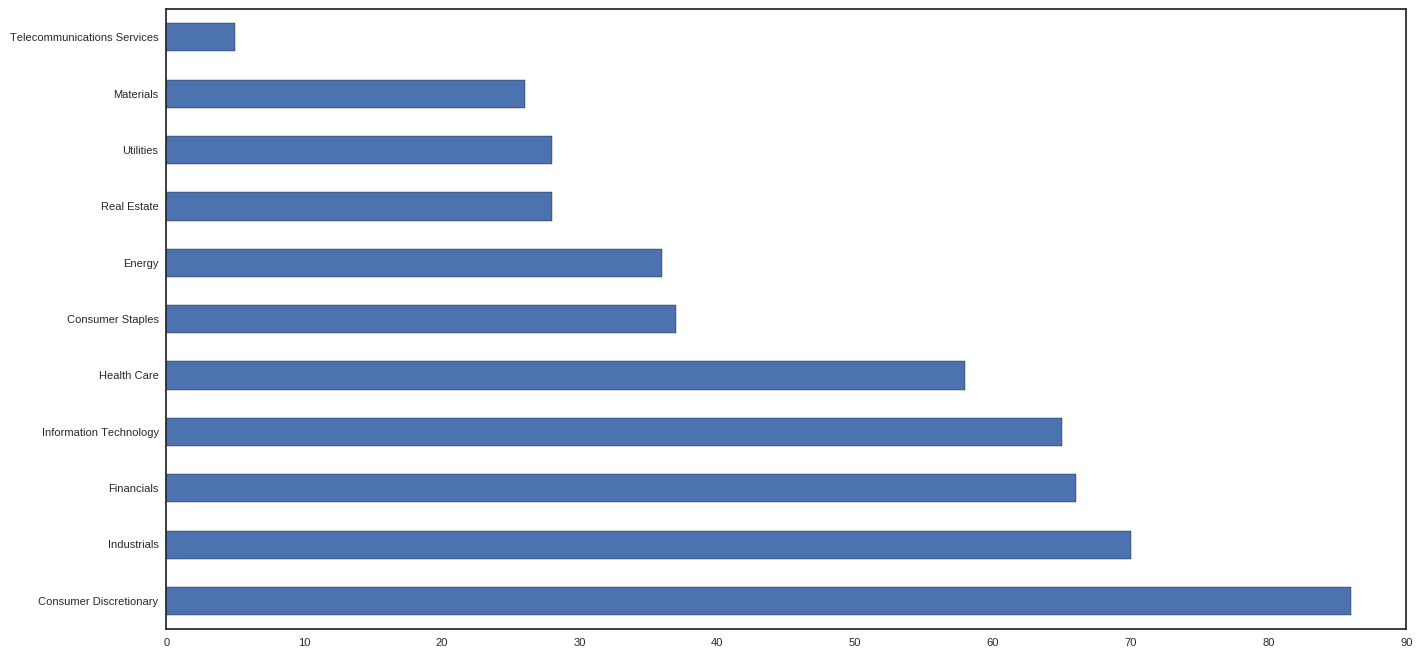

In [17]:
slr.set_style()
companies.GICS_Sector.value_counts().plot.barh(figsize=(16, 8))

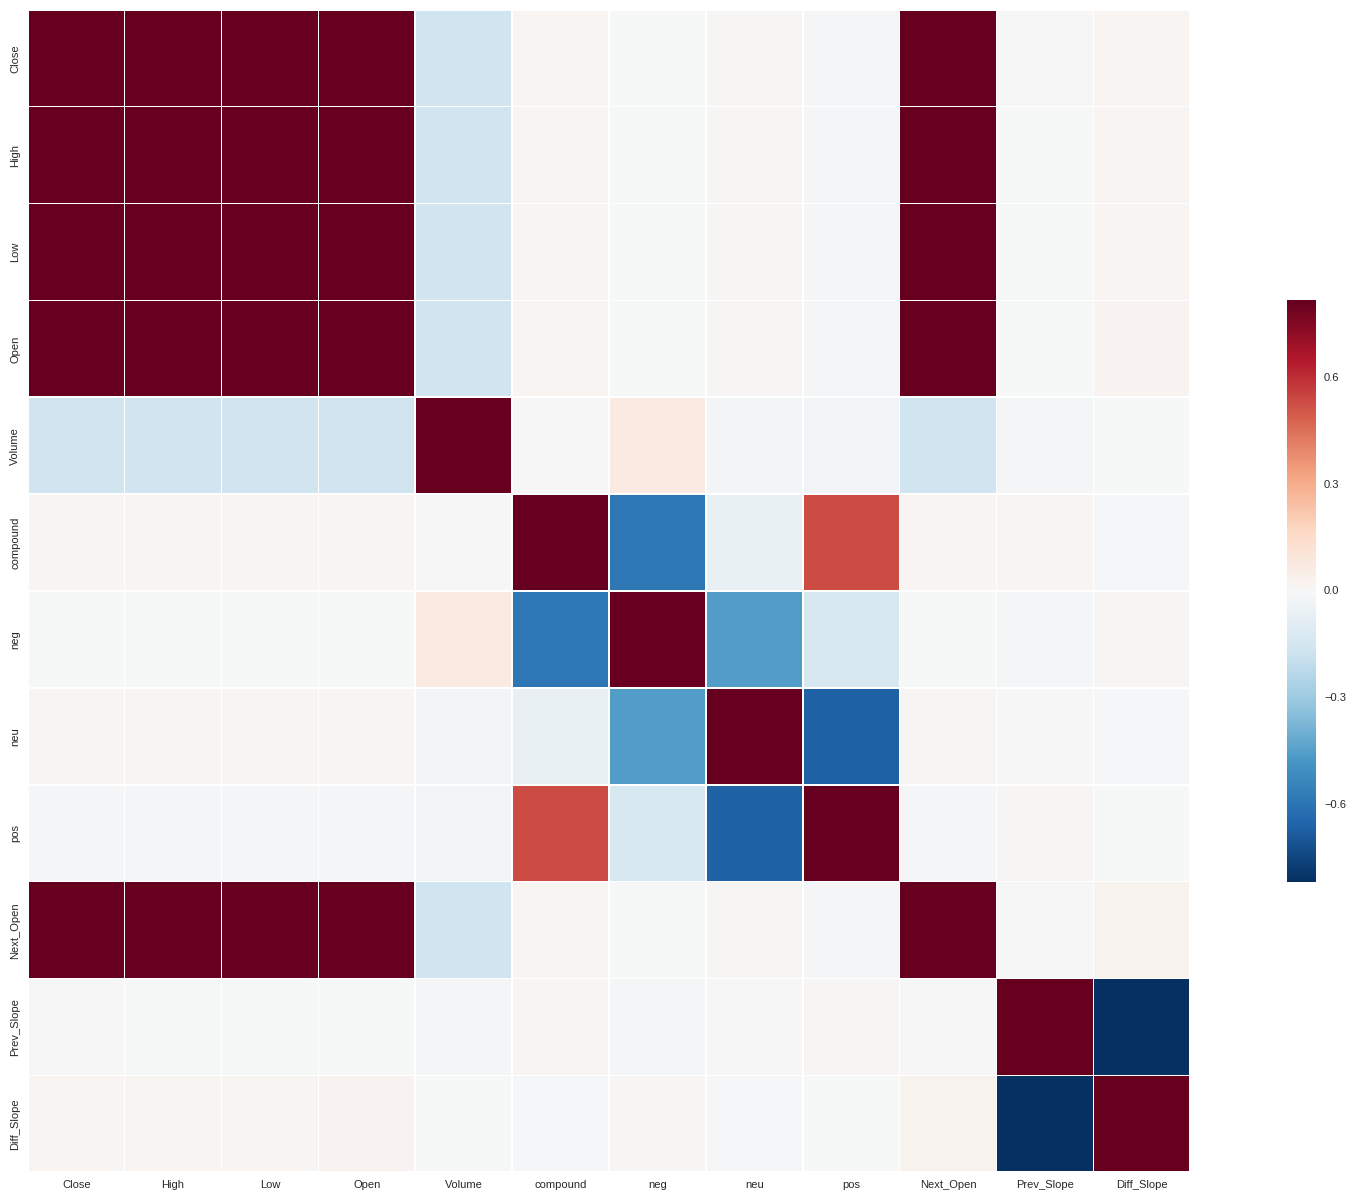

In [18]:
plt.figure(figsize=(25,15))
sns.heatmap(
    has_news[['Close', 'High', 'Low', 'Open', 'Volume',
              'compound', 'neg', 'neu', 'pos', 'Next_Open',
              'Prev_Slope', 'Diff_Slope']].corr(),
    vmax=.3,
    square=True, 
    linewidths=.5,
    cbar_kws={"shrink": .5})

In [19]:
x = has_news[['Close', 'High', 'Low', 'Open', 'Volume', 'compound',
              'neg', 'neu', 'pos', 'Next_Open', 'Prev_Slope']]
y = has_news['Diff_Slope']
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3)

# Modeling

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=False) 

Mean cross validation score                       0.873506630693
Model socre                                       0.937668213649
Explained variance regression score               0.937739569664
Mean Absolute Error                               1.11845051189

score for test data                               0.788205622001
RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100.0], cv=None, fit_intercept=True,
    gcv_mode=None, normalize=True, scoring=None, store_cv_values=False) 

Mean cross validation score                       0.465947273563
Model socre                                       0.608905392495
Explained variance regression score               0.609077889471
Mean Absolute Error                               1.51048523799

score for test data                               0.417763667538
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=N

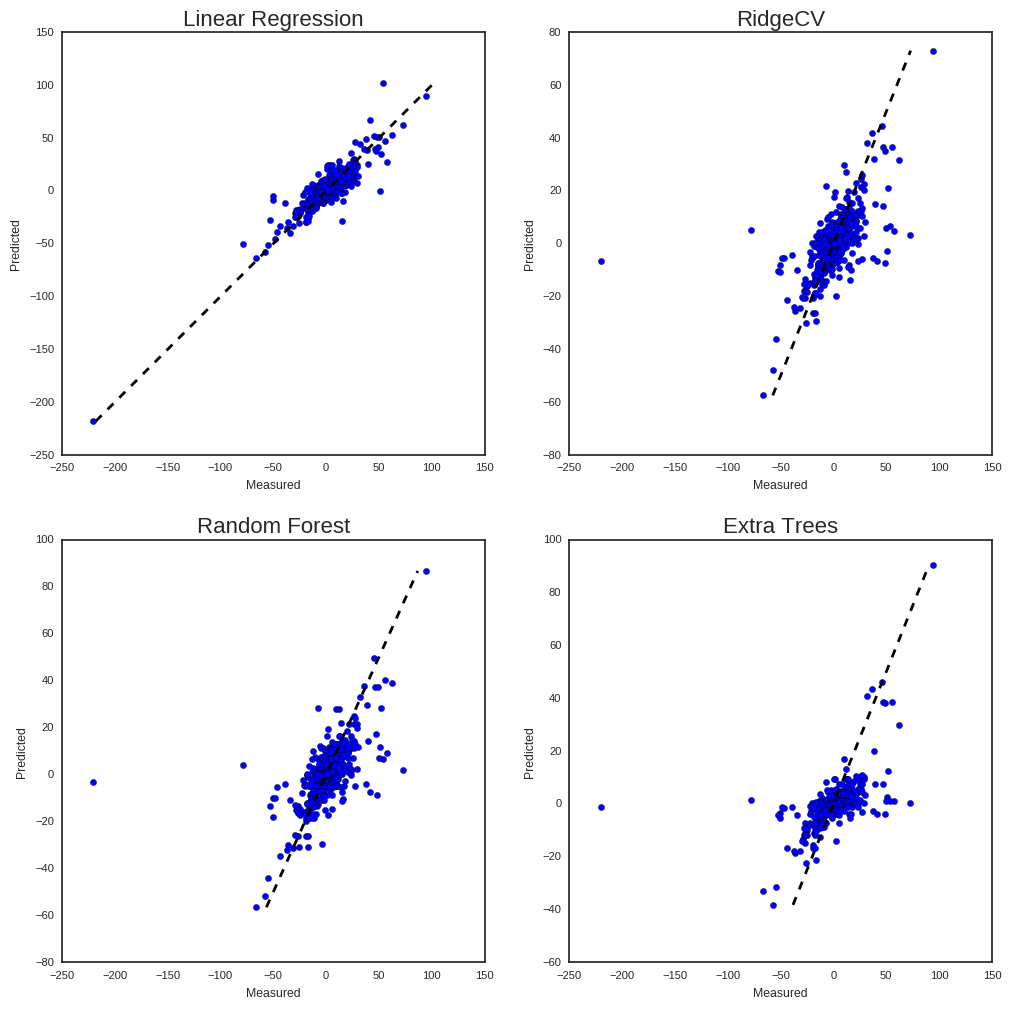

In [21]:
filename = 'datasets/models/all.sav'
all_dic = {}
if os.path.exists(filename):
    all_dic = joblib.load(filename)
else:
    all_dic['lr_model'], all_dic['lr_report'] = linear_regression(x_train, y_train)
    all_dic['rd_model'], all_dic['rd_report'] = ridge_cv(x_train, y_train)
    all_dic['rf_model'], all_dic['rf_report'] = random_forest(x_train, y_train)
    all_dic['et_model'], all_dic['et_report'] = extra_trees(x_train, y_train)

    sec_dic['size'] = x.shape[0]
    joblib.dump(sec_dic, filename)

slr.print_model_report(all_dic['lr_report'], 
                       model=all_dic['lr_model'], score=all_dic['lr_model'].score(x_test, y_test))
slr.print_model_report(all_dic['rd_report'], 
                       model=all_dic['rd_model'], score=all_dic['rd_model'].score(x_test, y_test))
slr.print_model_report(all_dic['rf_report'], 
                       model=all_dic['rf_model'], score=all_dic['rf_model'].score(x_test, y_test))
slr.print_model_report(all_dic['et_report'], 
                       model=all_dic['et_model'], score=all_dic['et_model'].score(x_test, y_test))

slr.plot_comparisions(y_test,
                  all_dic['lr_model'].predict(x_test),
                  all_dic['rd_model'].predict(x_test),
                  all_dic['rf_model'].predict(x_test),
                  all_dic['et_model'].predict(x_test)
                 )

In [22]:
sector_symbols = {}
for sector in companies.GICS_Sector.unique():
    sector_symbols[sector] = list(companies.Ticker_symbol[companies.GICS_Sector == sector])

Telecommunications Services
295


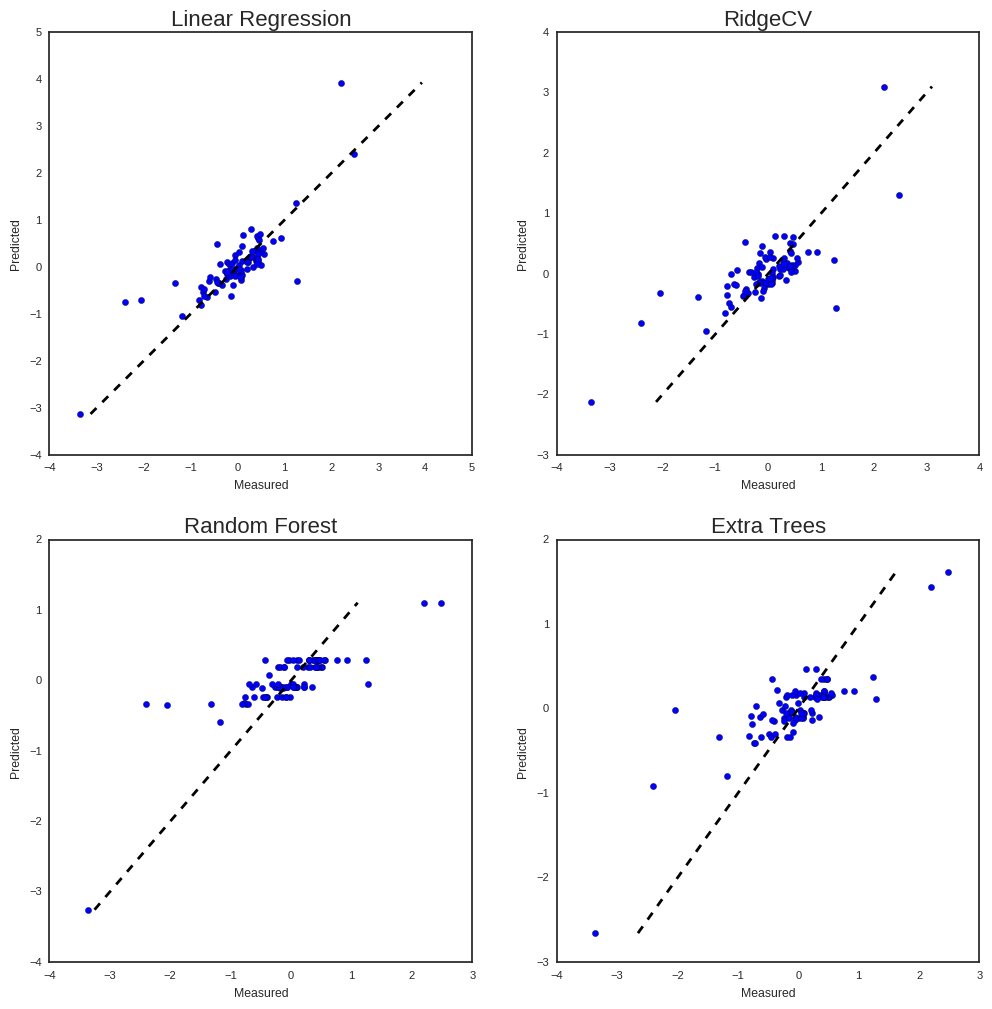

Industrials
2971


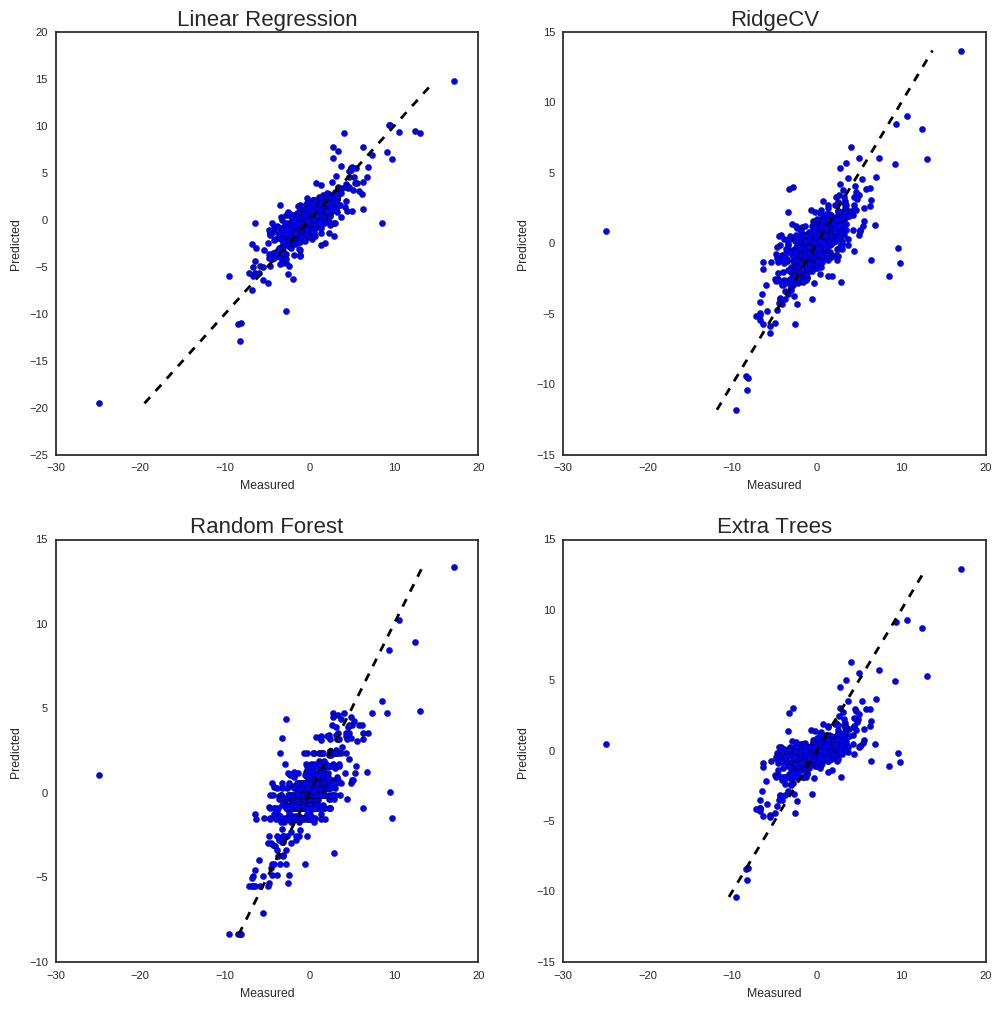

Consumer Discretionary
4521


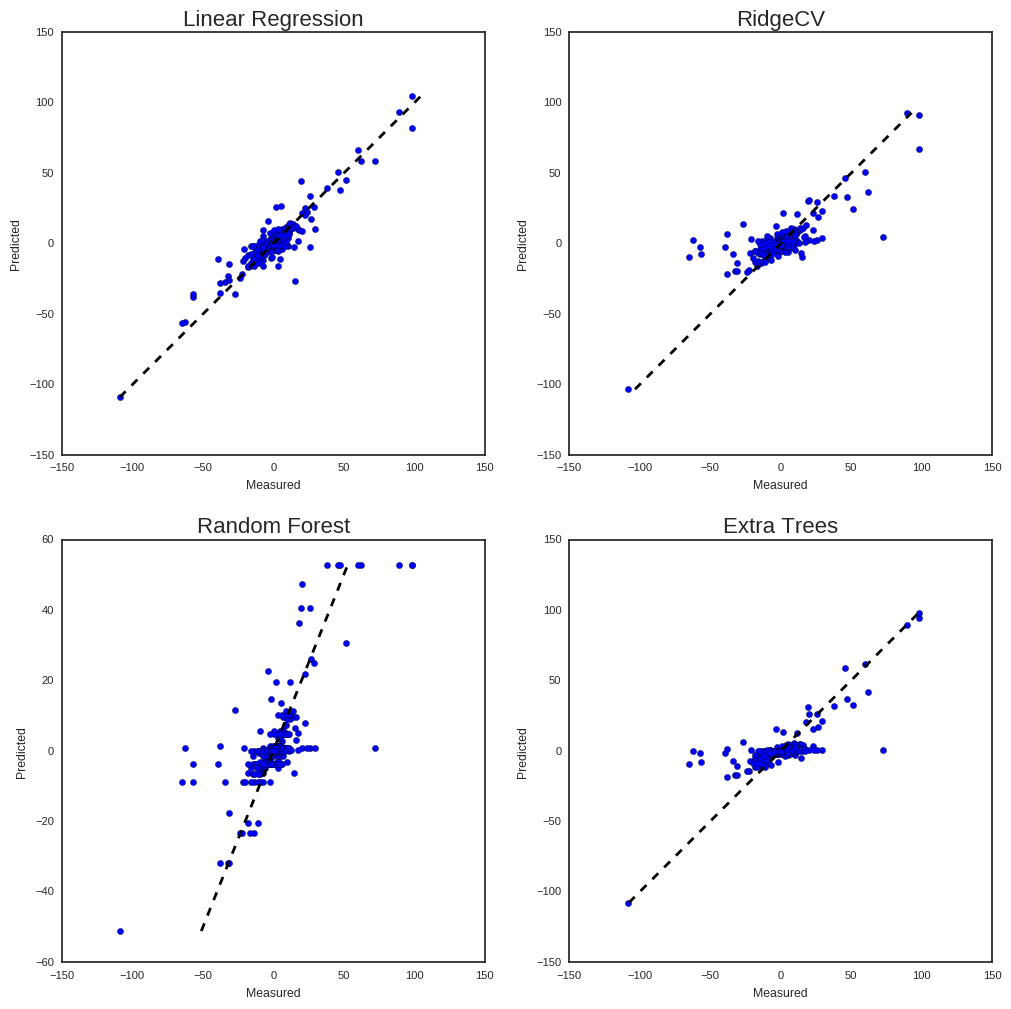

Utilities
507


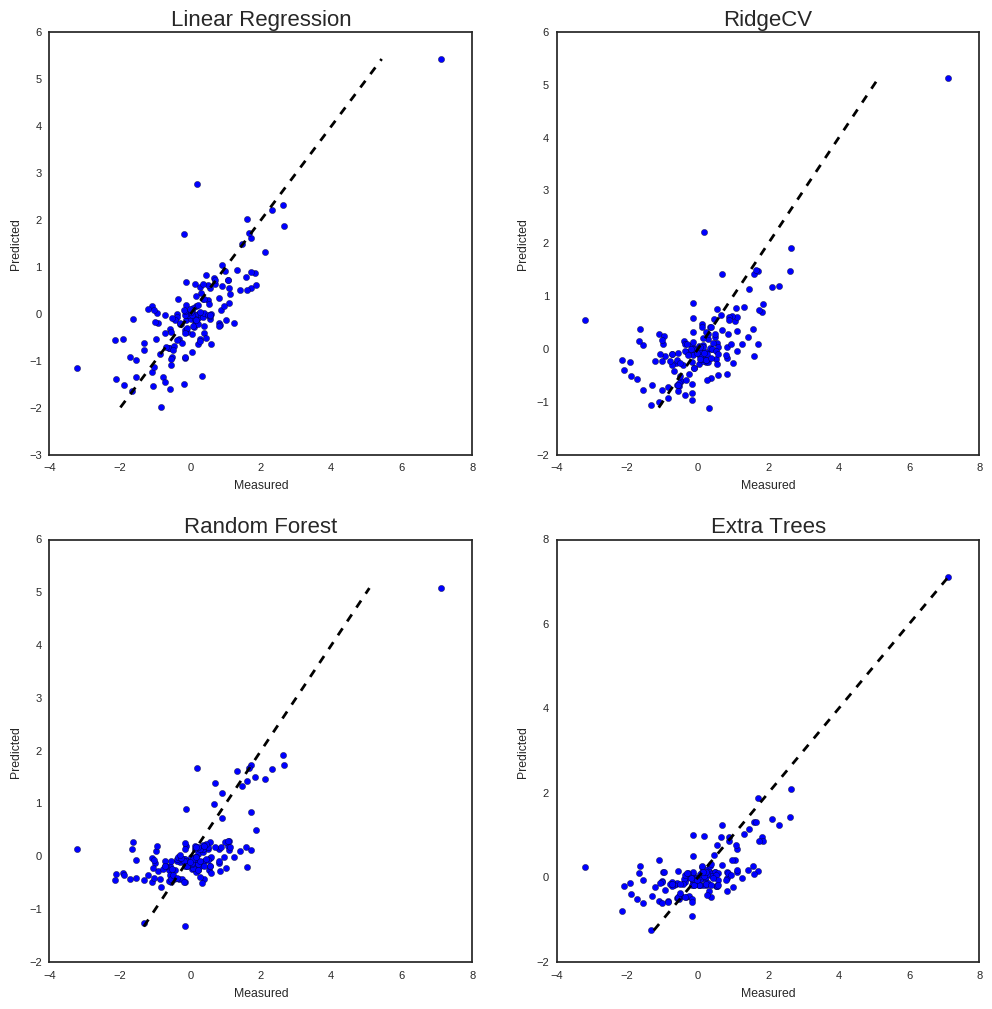

Consumer Staples
1619


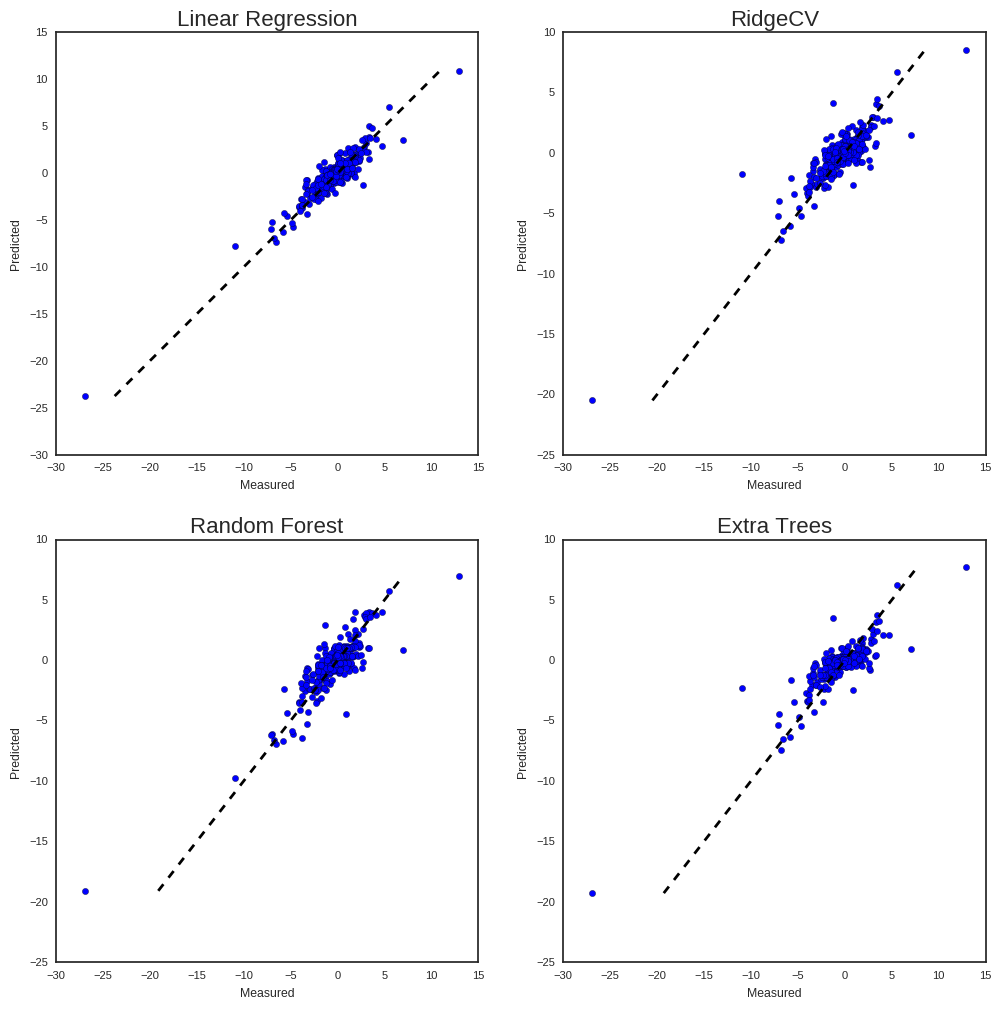

Health Care
3206


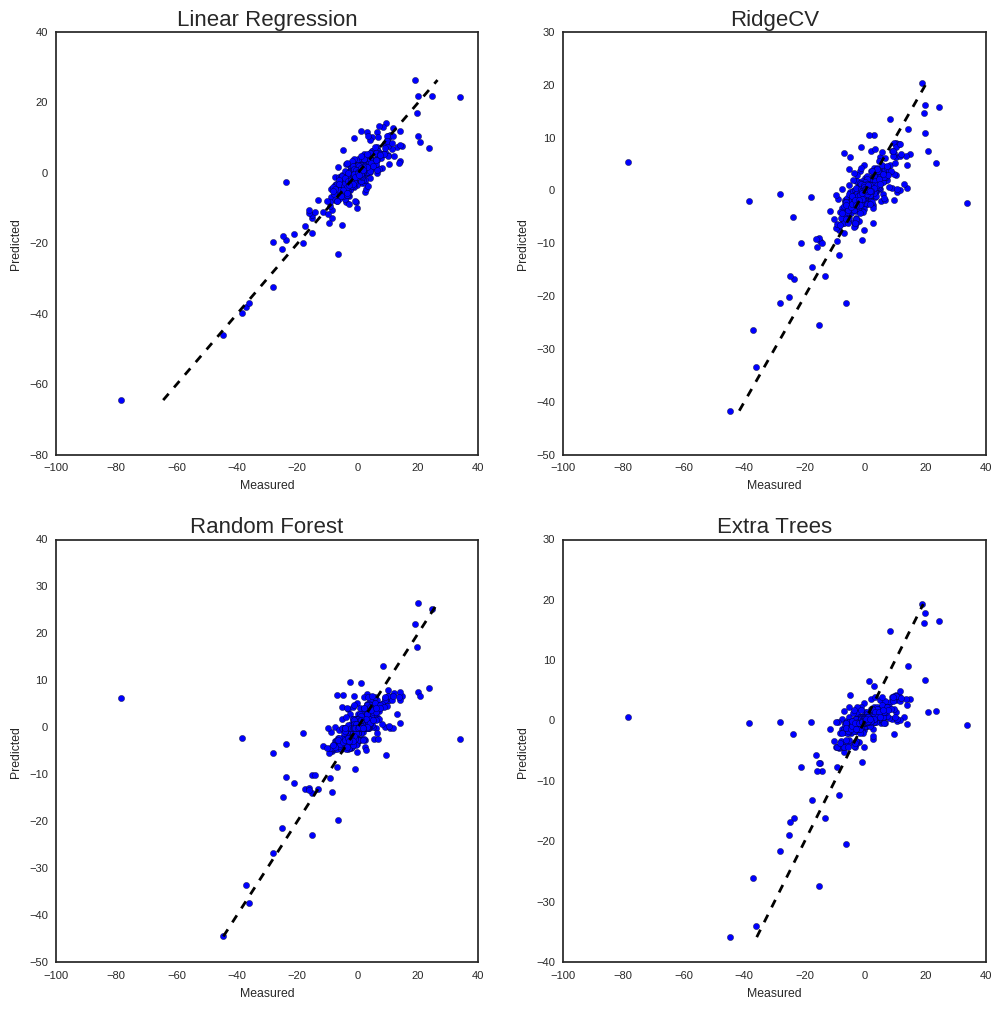

Materials
1054


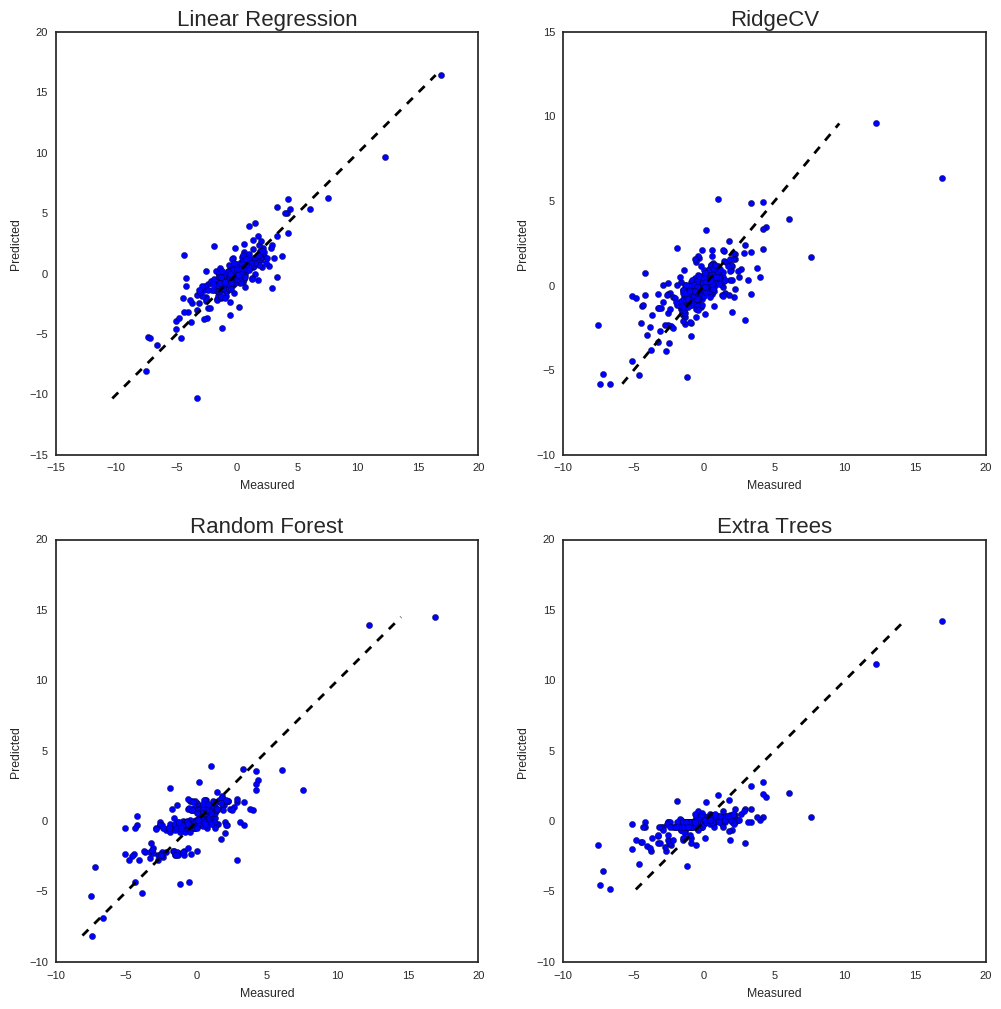

Information Technology
4704


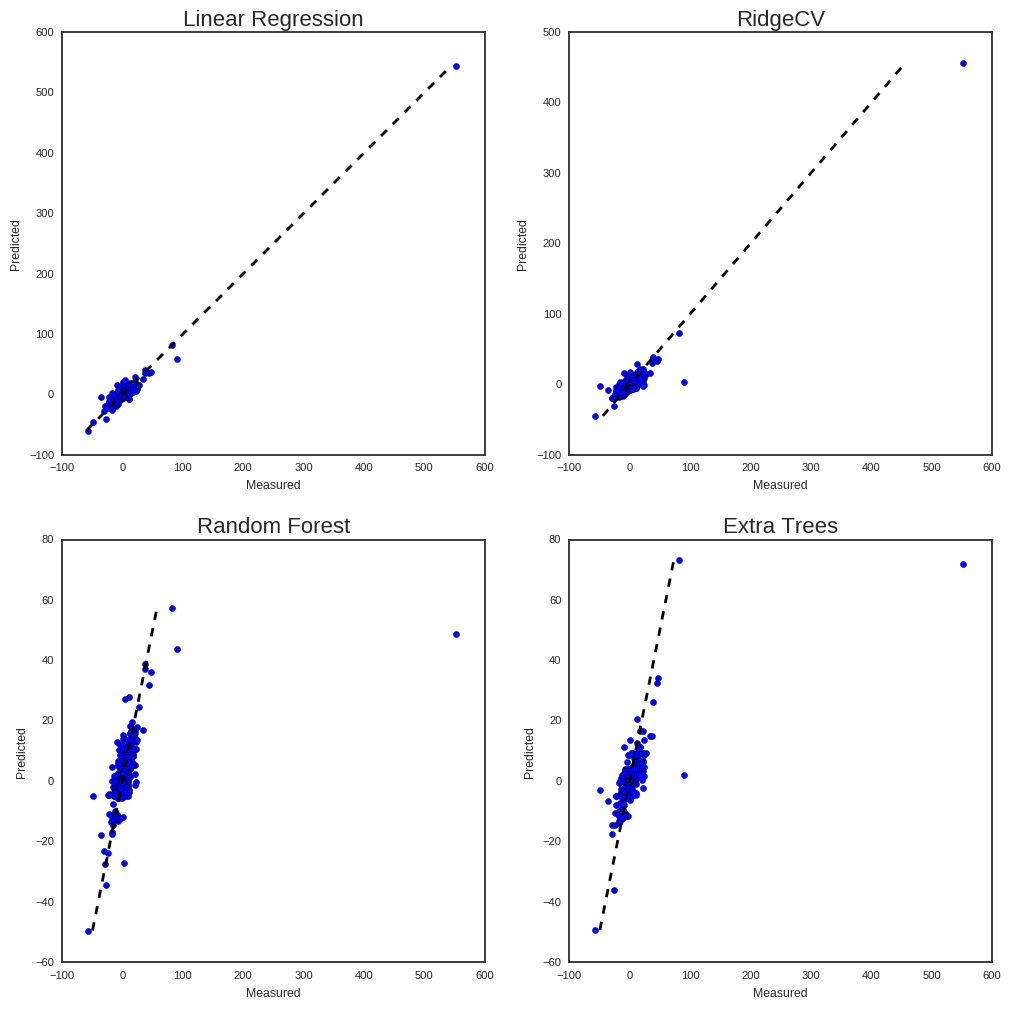

Real Estate
304


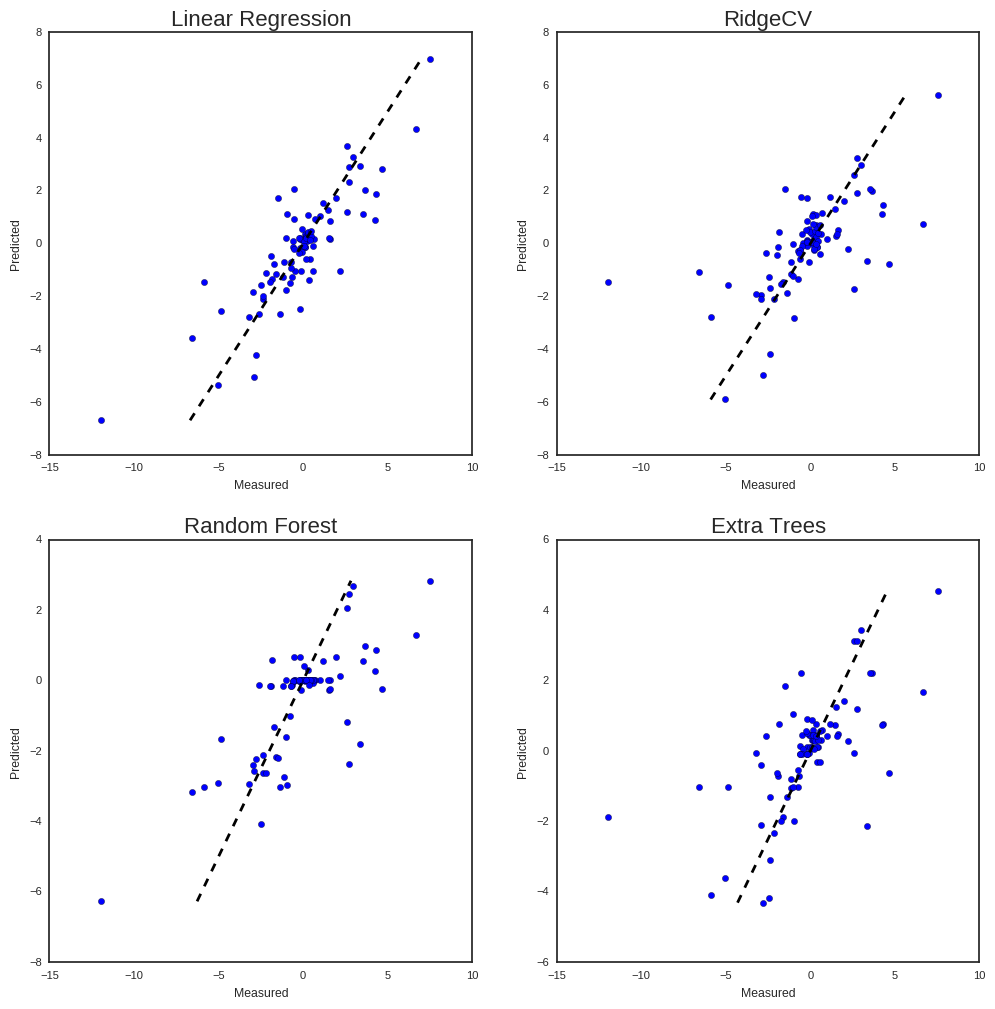

Energy
2127


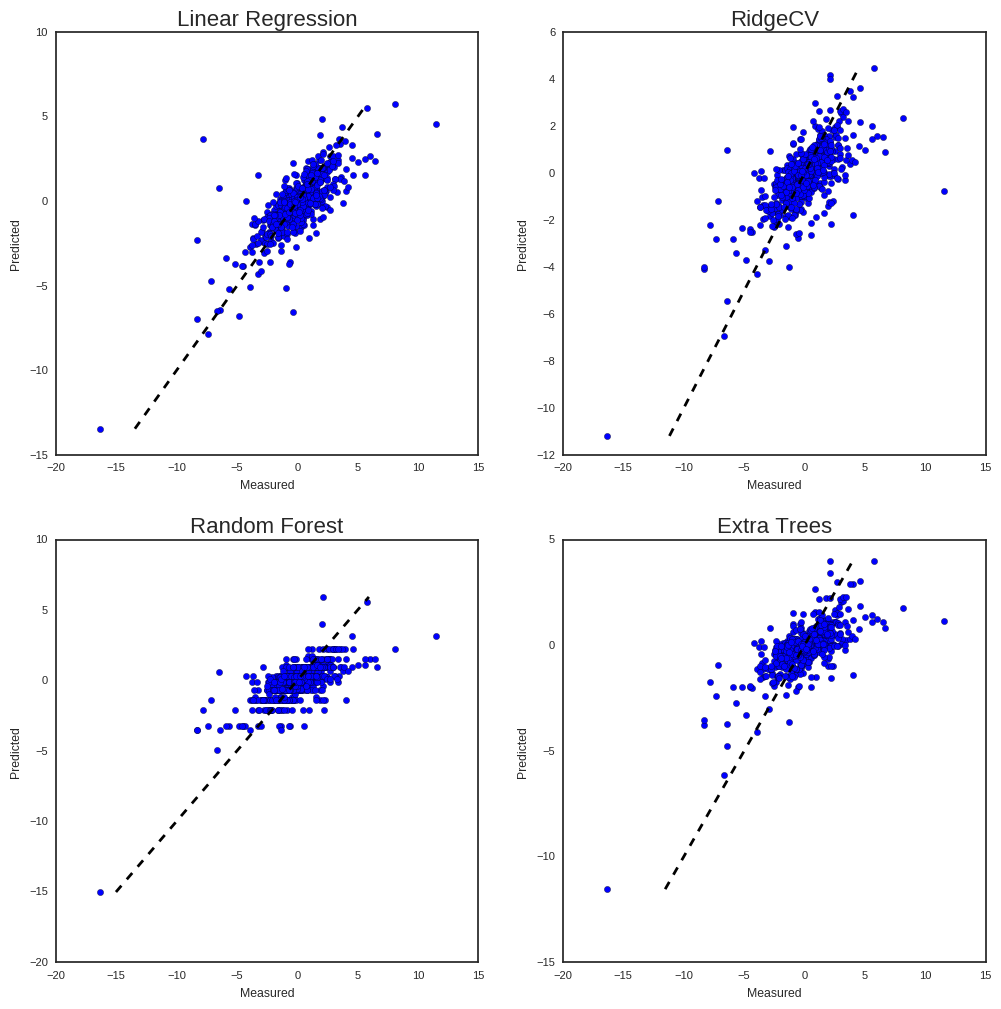

Financials
3934


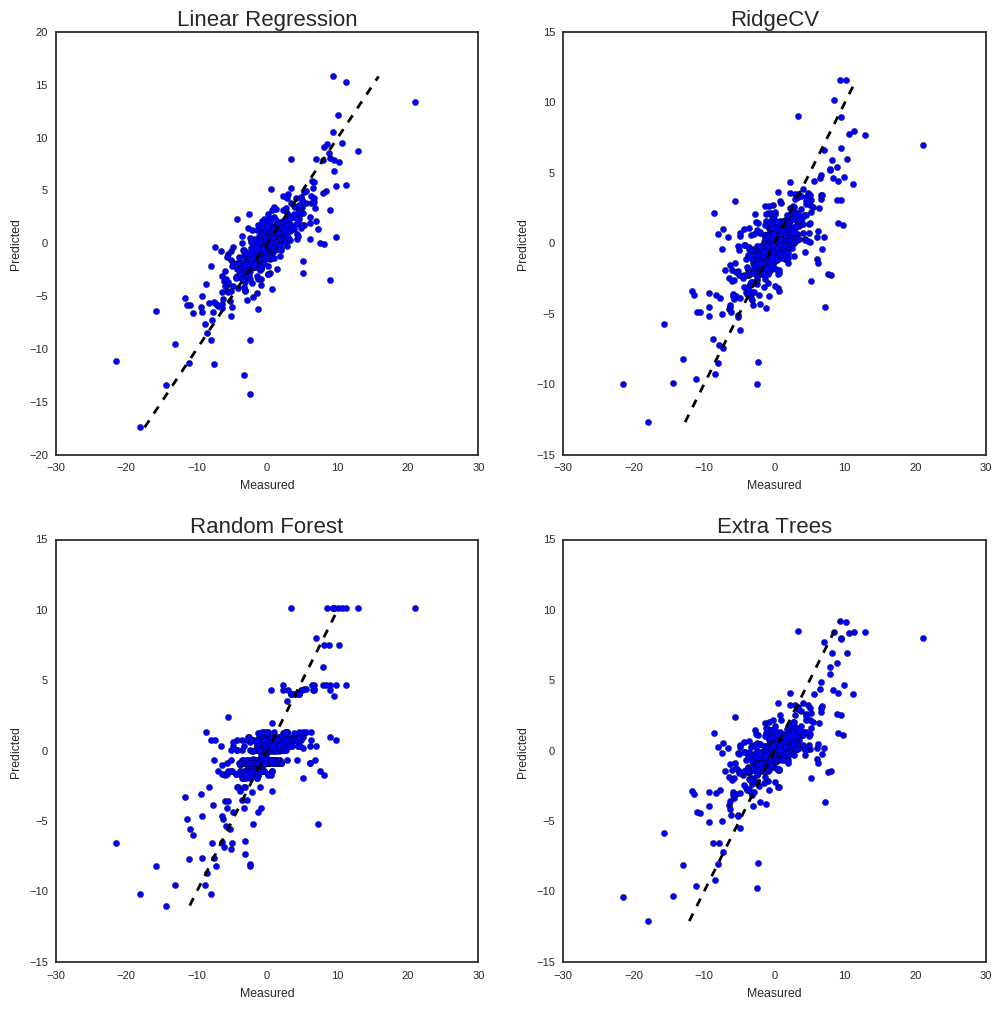

In [118]:
all_sectors = {}
for sector, symbols in sector_symbols.iteritems():
    sector_news = has_news[(has_news.Symbol.isin(sector_symbols[sector]))]

    sec_x = sector_news[['Close', 'High', 'Low', 'Open', 'Volume', 'compound',
                         'neg', 'neu', 'pos', 'Next_Open', 'Prev_Slope']]
    sec_y = sector_news['Diff_Slope']
    sec_x_train, sec_x_test, sec_y_train, sec_y_test=train_test_split(sec_x, sec_y, test_size=0.3)
    print sector

    filename = 'datasets/models/{}.sav'.format(sector.replace(' ', '_'))

    sec_dic = {}
    if os.path.exists(filename):
        sec_dic = joblib.load(filename)
    else:
        sec_dic['lr_model'], sec_dic['lr_report'] = linear_regression(sec_x_train, sec_y_train)
        sec_dic['rd_model'], sec_dic['rd_report'] = ridge_cv(sec_x_train, sec_y_train)
        sec_dic['rf_model'], sec_dic['rf_report'] = random_forest(sec_x_train, sec_y_train)
        sec_dic['et_model'], sec_dic['et_report'] = extra_trees(sec_x_train, sec_y_train)
        joblib.dump(sec_dic, filename)
        
    sec_dic['size'] = sec_x.shape[0]
    sec_dic['lr_score'] = sec_dic['lr_model'].score(sec_x_test, sec_y_test)
    sec_dic['rd_score'] = sec_dic['rd_model'].score(sec_x_test, sec_y_test)
    sec_dic['rf_score'] = sec_dic['rf_model'].score(sec_x_test, sec_y_test)
    sec_dic['et_score'] = sec_dic['et_model'].score(sec_x_test, sec_y_test)

    print sec_dic['size']
    all_sectors[sector] = sec_dic
    
#     print print_comparisions(sec_y_test, sec_x_test,
#                              sec_dic['lr_model'],
#                              sec_dic['rd_model'],
#                              sec_dic['rf_model'],
#                              sec_dic['et_model'],
#                              title = sector
#                      )
    slr.plot_comparisions(sec_y_test,
                      sec_dic['lr_model'].predict(sec_x_test),
                      sec_dic['rd_model'].predict(sec_x_test),
                      sec_dic['rf_model'].predict(sec_x_test),
                      sec_dic['et_model'].predict(sec_x_test)
                     )

In [119]:
sector_report = pd.DataFrame(all_sectors)
sector_report

,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunications Services,Utilities
et_model,"(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth..."
et_report,{u'Mean cross validation score': 0.60211385388...,{u'Mean cross validation score': 0.66079284775...,{u'Mean cross validation score': 0.48642056702...,{u'Mean cross validation score': 0.50515391420...,{u'Mean cross validation score': 0.52798989352...,{u'Mean cross validation score': 0.49813394206...,{u'Mean cross validation score': 0.18555888266...,{u'Mean cross validation score': 0.40351303168...,{u'Mean cross validation score': 0.19847564222...,{u'Mean cross validation score': 0.49279256347...,{u'Mean cross validation score': 0.38455707306...
et_score,0.634149,0.713195,0.487684,0.553526,0.418424,0.465232,0.291775,0.561571,0.409143,0.629101,0.558541
lr_model,"LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa..."
lr_report,{u'Mean cross validation score': 0.81539364167...,{u'Mean cross validation score': 0.80407763068...,{u'Mean cross validation score': 0.65910078636...,{u'Mean cross validation score': 0.70199561737...,{u'Mean cross validation score': 0.77328491364...,{u'Mean cross validation score': 0.75504674141...,{u'Mean cross validation score': 0.79589554780...,{u'Mean cross validation score': 0.66963059716...,{u'Mean cross validation score': 0.20861557284...,{u'Mean cross validation score': 0.57409301441...,{u'Mean cross validation score': 0.53850358963...
lr_score,0.860845,0.865339,0.6073,0.68646,0.821732,0.732485,0.954434,0.730825,0.719001,0.682868,0.599854
rd_model,"RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100...."
rd_report,{u'Mean cross validation score': 0.56885561943...,{u'Mean cross validation score': 0.73462525030...,{u'Mean cross validation score': 0.52503687444...,{u'Mean cross validation score': 0.55526012691...,{u'Mean cross validation score': 0.69973514595...,{u'Mean cross validation score': 0.57620177504...,{u'Mean cross validation score': 0.45954706516...,{u'Mean cross validation score': 0.67541883233...,{u'Mean cross validation score': 0.32428506827...,{u'Mean cross validation score': 0.54809963668...,{u'Mean cross validation score': 0.41204133111...
rd_score,0.63943,0.737124,0.48465,0.55509,0.458297,0.490212,0.893972,0.55958,0.410578,0.561611,0.472204
rf_model,"(DecisionTreeRegressor(criterion='mse', max_de...","(DecisionTreeRegressor(criterion

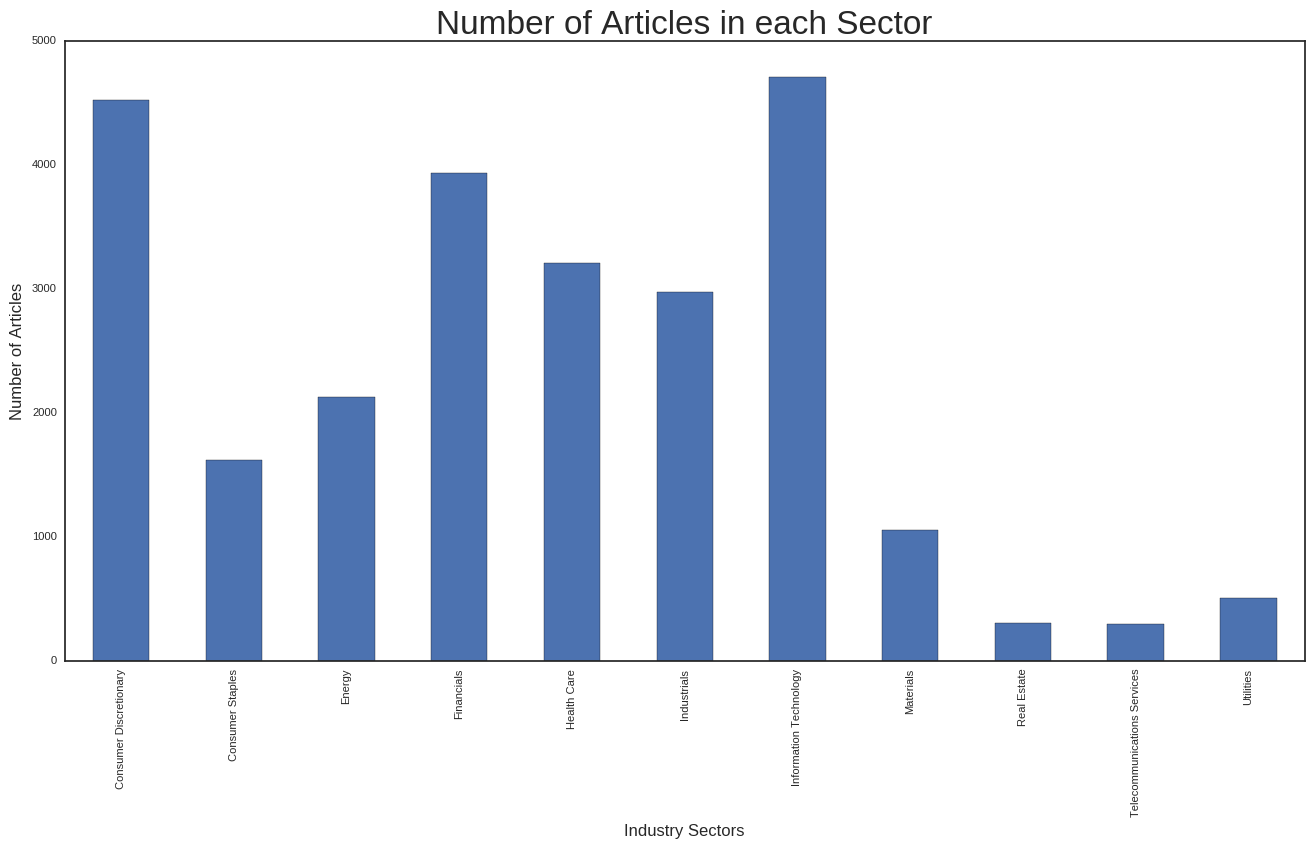

In [120]:
slr.set_style()
ax = sector_report.loc['size', :].plot.bar(figsize=(16, 8))
ax.set_ylabel("Number of Articles", fontsize=12)
ax.set_xlabel("Industry Sectors", fontsize=12)
ax.set_title('Number of Articles in each Sector', fontsize=24)

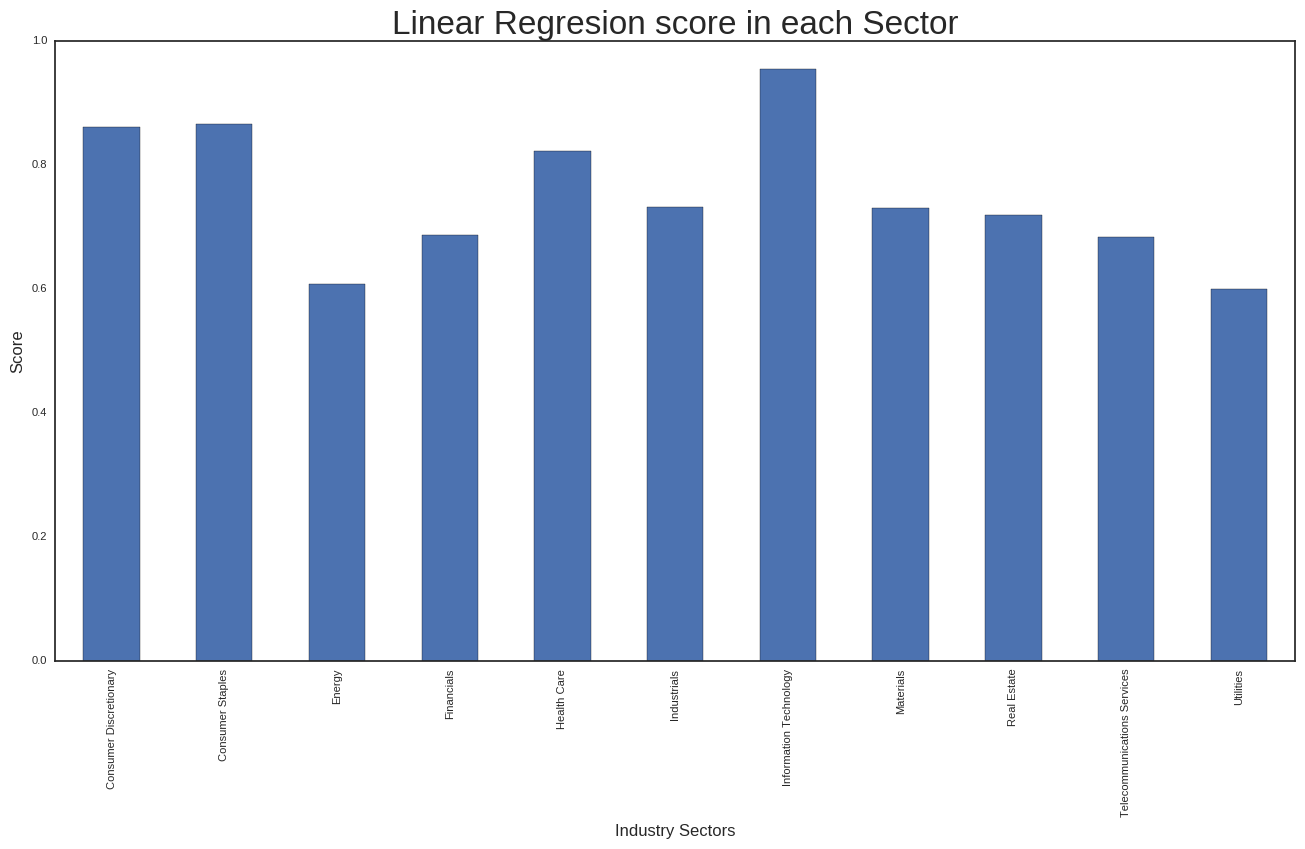

In [121]:
slr.set_style()
ax = sector_report.loc['lr_score', :].plot.bar(figsize=(16, 8))
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("Industry Sectors", fontsize=12)
ax.set_title('Linear Regresion score in each Sector', fontsize=24)

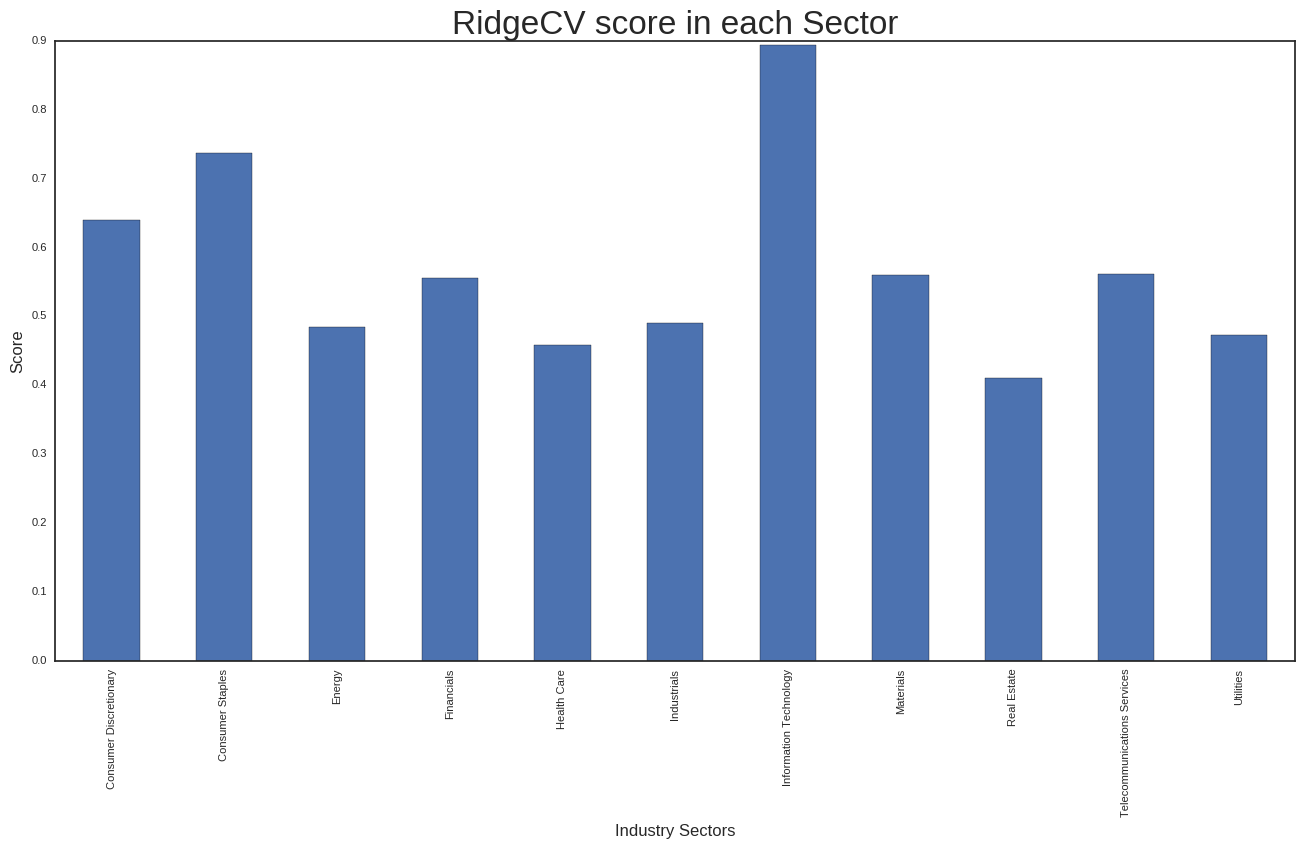

In [122]:
slr.set_style()
ax = sector_report.loc['rd_score', :].plot.bar(figsize=(16, 8))
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("Industry Sectors", fontsize=12)
ax.set_title('RidgeCV score in each Sector', fontsize=24)

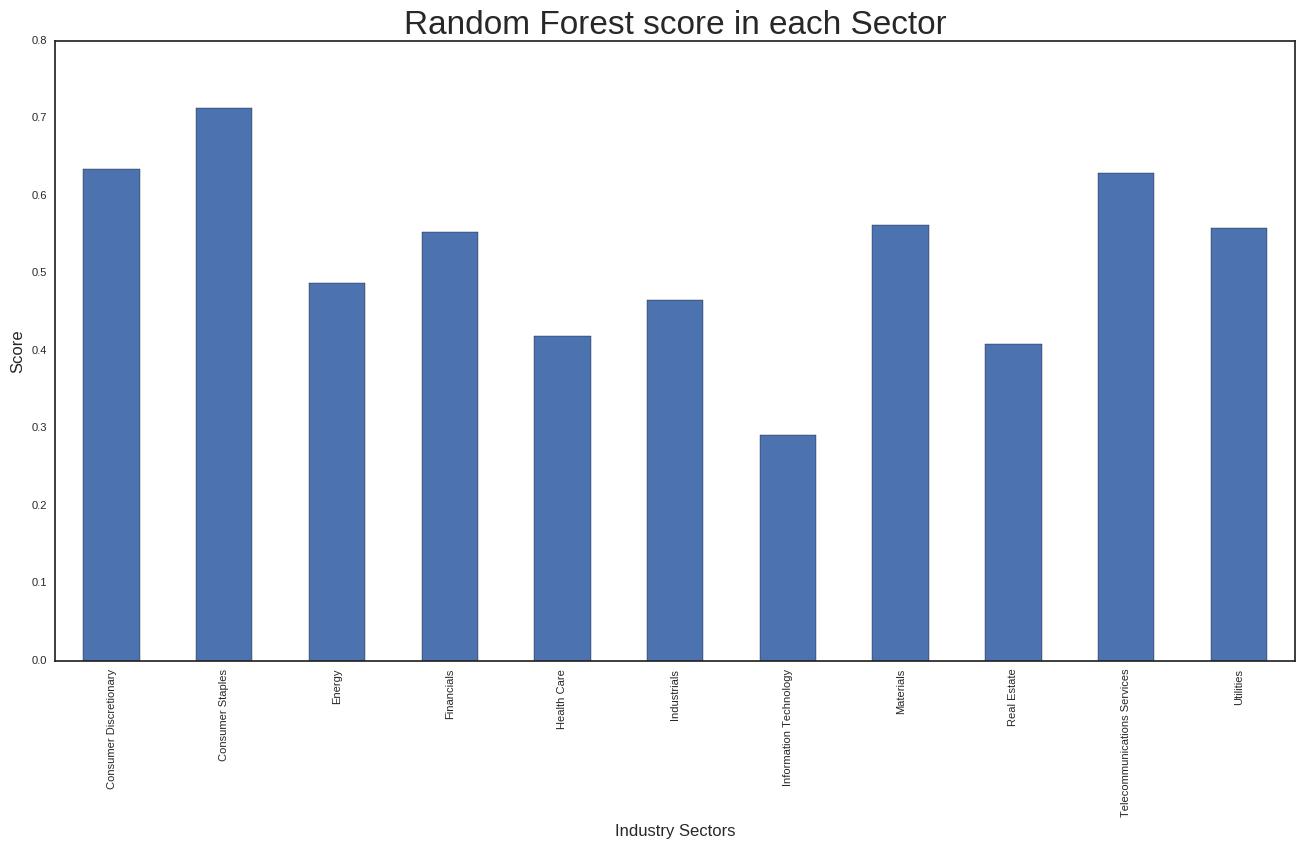

In [123]:
slr.set_style()
ax = sector_report.loc['et_score', :].plot.bar(figsize=(16, 8))
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("Industry Sectors", fontsize=12)
ax.set_title('Random Forest score in each Sector', fontsize=24)

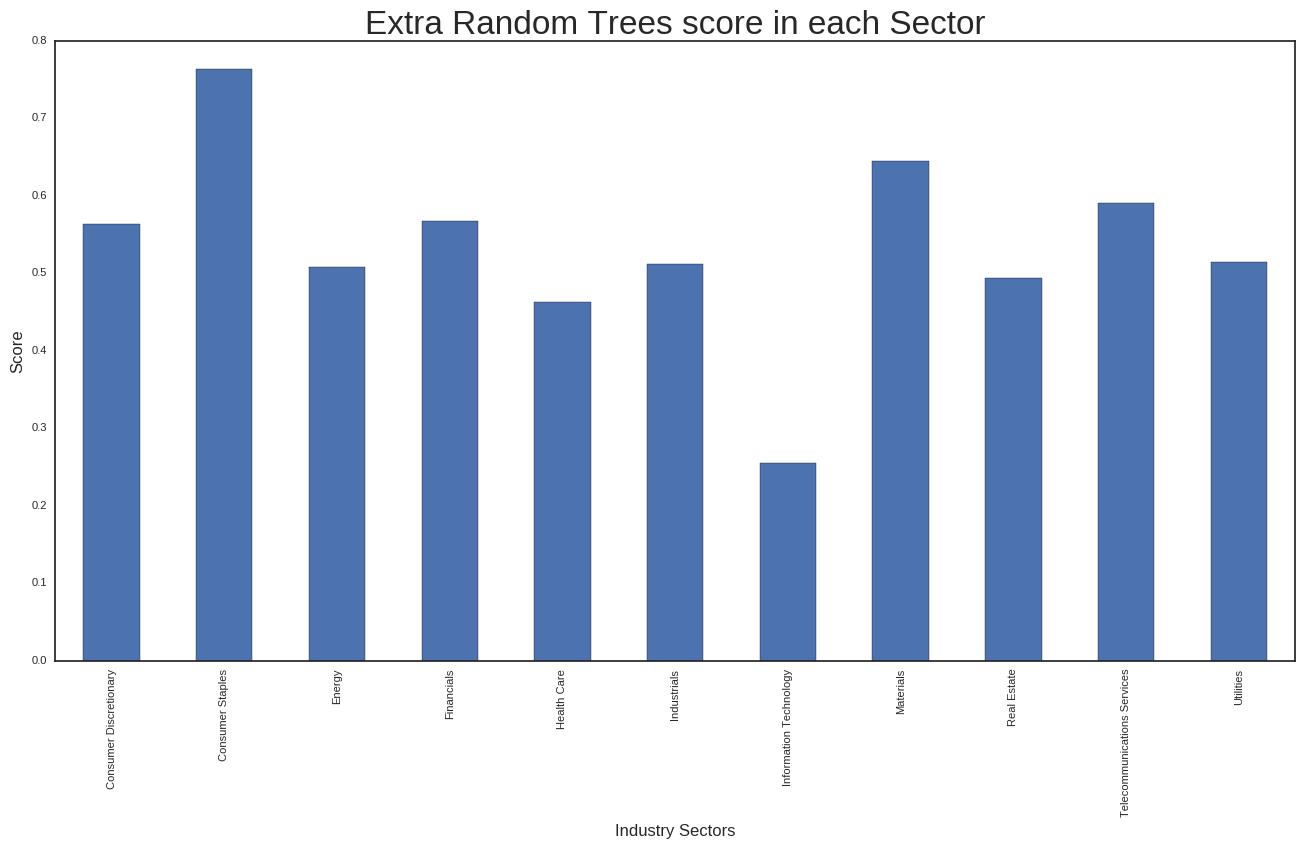

In [124]:
slr.set_style()
ax = sector_report.loc['rf_score', :].plot.bar(figsize=(16, 8))
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("Industry Sectors", fontsize=12)
ax.set_title('Extra Random Trees score in each Sector', fontsize=24)

In [125]:
lr_means = pd.DataFrame(
    [[key, ms['Mean cross validation score']] for key, ms in sector_report.loc['lr_report', :].iteritems()],
    columns=['sectors', 'lr'])

rd_means = pd.DataFrame(
    [[key, ms['Mean cross validation score']] for key, ms in sector_report.loc['rd_report', :].iteritems()])
rf_means = pd.DataFrame(
    [[key, ms['Mean cross validation score']] for key, ms in sector_report.loc['rf_report', :].iteritems()])
et_means = pd.DataFrame(
    [[key, ms['Mean cross validation score']] for key, ms in sector_report.loc['et_report', :].iteritems()])
means = pd.concat([lr_means, rd_means, rf_means, et_means], axis=1).drop(0, axis=1).set_index('sectors')
means.columns = ['Linear Regression', 'RidgeCV', 'Random Forest', 'Extra Trees']
means

,Linear Regression,RidgeCV,Random Forest,Extra Trees
sectors,,,,
Consumer Discretionary,0.815394,0.568856,0.368344,0.602114
Consumer Staples,0.804078,0.734625,0.613334,0.660793
Energy,0.659101,0.525037,0.483263,0.486421
Financials,0.701996,0.555260,0.486163,0.505154
Health Care,0.773285,0.699735,0.574982,0.527990
Industrials,0.755047,0.576202,0.503148,0.498134
Information Technology,0.795896,0.459547,-0.065005,0.185559
Materials,0.669631,0.675419,0.602871,0.403513
Real Estate,0.208616,0.324285,0.246056,0.198476


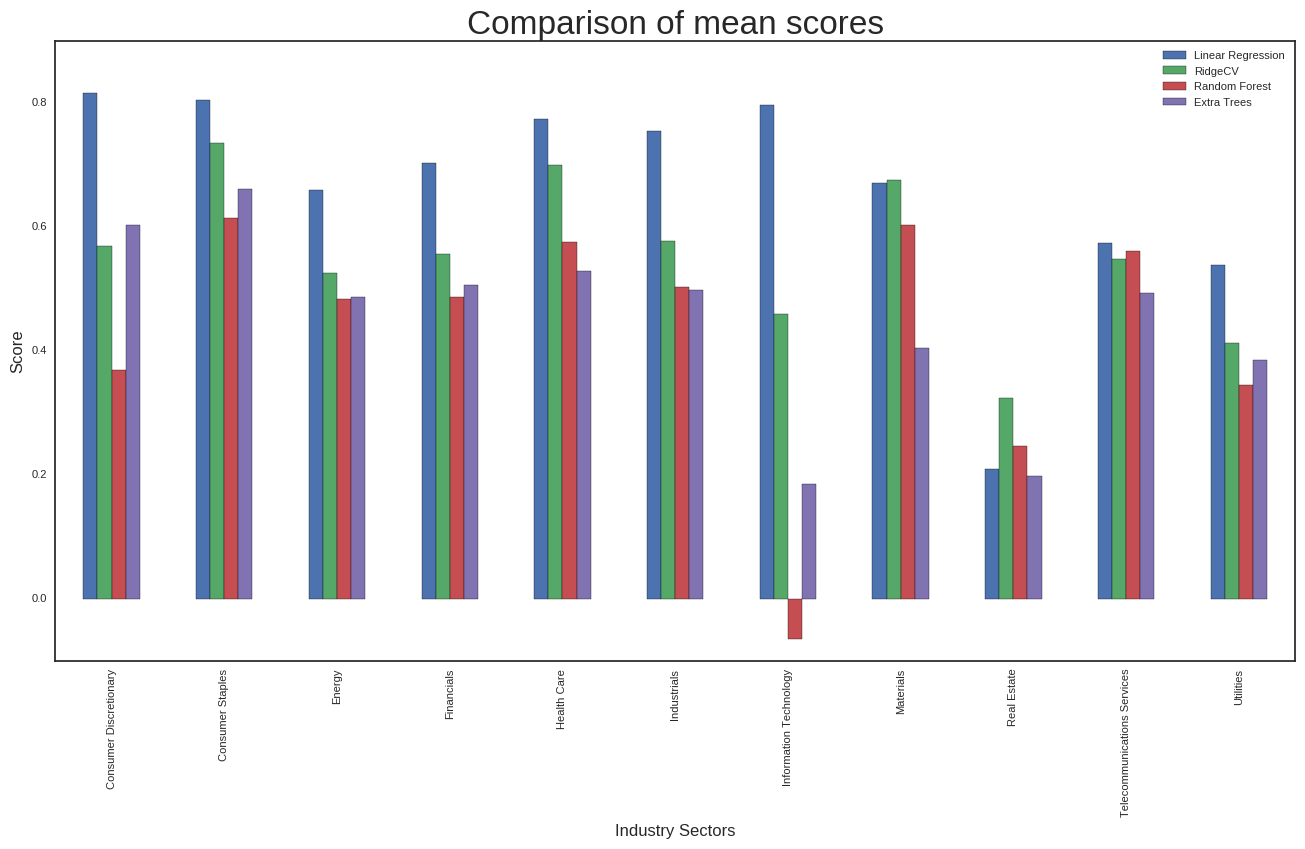

In [127]:
# means.plot.bar()
slr.set_style()
ax = means.plot.bar(figsize=(16, 8))
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("Industry Sectors", fontsize=12)
ax.set_title('Comparison of mean scores', fontsize=24)
